**PROJET TAL** : Classification de morceaux de discours appartenants aux anciens présidents de la République française : François Mitterand et Jacques Chirac

**Librairies nécessaires**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import codecs
import re
import os
import os.path
import string
import time
import logging
import sys
import math

from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torch.nn as nn
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"
print(device)

from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

C:\Users\Melo\AppData\Local\Temp\ipykernel_19708\75326100.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


cpu


### ÉTAPE 1 : CHARGEMENT DES JEUX DE DONNÉES (INSPIRATION DU NOTEBOOK "APPLICATION" DE MR GUIGUE)

In [2]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt).strip()
        if lab.count('M') >0:
            alllabs.append(0)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs

In [3]:
trainCorpus = "./ressources/AFDpresidentutf8/corpus.tache1.learn.utf8"
testCorpus = "./ressources/AFDpresidentutf8/corpus.tache1.test.utf8"

alltxts_train, alllabs_train = load_pres(trainCorpus)
alltxts_test, alllabs_test = load_pres(testCorpus)

In [4]:
print(len(alltxts_train),len(alllabs_train))
print(alltxts_train[:3])
print(alllabs_train[:3])
print(alltxts_train[-1])
print(alllabs_train[-1])

57413 57413
["Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.", "D'abord merci de cet exceptionnel accueil que les Congolais, les Brazavillois, nous ont réservé cet après-midi.", "C'est toujours très émouvant de venir en Afrique car c'est probablement l'une des rares terres du monde où l'on ait conservé cette convivialité, cette amitié, ce respect de l'autre qui s'expriment avec chaleur, avec spontanéité et qui réchauffent le coeur de ceux qui arrivent et de ceux qui reçoivent."]
[1, 1, 1]
Je compte sur vous.
1


In [5]:
counter_train = Counter(alllabs_train)
counter_test = Counter(alllabs_test)

print("Nombre de phrases du corpus d'entraînement : ", len(alltxts_train))
print("----> # de l'ancien président français Jacques Chirac (label '1') : ", counter_train[1])
print("----> # de l'ancien président français François Mitterand (label '0') : ", counter_train[-1])

print("Nombre de phrases du corpus de test : ", len(alllabs_test))
print("----> # de l'ancien président français Jacques Chirac (label '1') : ", counter_test[1])
print("----> # de l'ancien président français François Mitterand (label '0') : ", counter_test[-1])

Nombre de phrases du corpus d'entraînement :  57413
----> # de l'ancien président français Jacques Chirac (label '1') :  49890
----> # de l'ancien président français François Mitterand (label '-1') :  0
Nombre de phrases du corpus de test :  27162
----> # de l'ancien président français Jacques Chirac (label '1') :  24244
----> # de l'ancien président français François Mitterand (label '-1') :  0


### ÉTAPE 2 : PRE-PROCESSING

In [6]:
def supp_numbers(text):
    """suppress numbers"""
    text = re.sub('[0-9]+', '', text)
    return text # remplacer une séquence de chiffres par rien

In [7]:
def supp_ponctuation(text):
    """retrieving (and suppressing) ponctuation"""
    punc = string.punctuation  
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))  
    return text

In [8]:
#Application du preprocessing à mon texte d'apprentissage et de test
alltxts_train_prep = []
alltxts_test_prep = []
for train_sentence in alltxts_train:
    alltxt_prep = supp_numbers(train_sentence)
    alltxt_prep = supp_ponctuation(alltxt_prep)

    alltxts_train_prep += [alltxt_prep]

for test_sentence in alltxts_test:
    alltxt_prep = supp_numbers(test_sentence)
    alltxt_prep = supp_ponctuation(alltxt_prep)

    alltxts_test_prep += [alltxt_prep]

In [9]:
alltxts_train_prep

['Quand je dis chers amis  il ne s agit pas là d une formule diplomatique  mais de l expression de ce que je ressens ',
 'D abord merci de cet exceptionnel accueil que les Congolais  les Brazavillois  nous ont réservé cet après midi ',
 'C est toujours très émouvant de venir en Afrique car c est probablement l une des rares terres du monde où l on ait conservé cette convivialité  cette amitié  ce respect de l autre qui s expriment avec chaleur  avec spontanéité et qui réchauffent le coeur de ceux qui arrivent et de ceux qui reçoivent ',
 'Aucun citoyen français ne peut être indifférent à un séjour à Brazzaville ',
 'Le Congo  que naguère le  nom  qualifia de  refuge pour la liberté   de  base de départ pour la libération   de  môle pour la Résistance   comment ne pas être heureux de s y retrouver  ',
 'Comment ne pas y voir un signe  ',
 'Brazzaville n est pas une capitale ordinaire ',
 'Les voies de la libre disposition des peuples et de leur coopération furent explorées il y a un dem

### ÉTAPE 3 : BAG OF WORDS

In [200]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(alltxts_train_prep)

In [201]:
print(vectorizer.get_feature_names_out()) #tous les mots différents du texte

['aaron' 'ab' 'abaissaient' ... 'ôtent' 'ôter' 'ôté']


In [203]:
#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, alllabs_train)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
lr_clf.fit(X, alllabs_train)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X, alllabs_train)

true = alllabs_test
test_corpus = alltxts_test_prep
X_test = vectorizer.transform(test_corpus)

pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)

print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")

Naïve Bayes accuracy: 0.8082247257197556
Logistic Regression accuracy: 0.832891539650983
SVM accuracy: 0.8108386716736617


In [204]:
#IDEM MAIS SANS PRE-PROCESSING
X = vectorizer.fit_transform(alltxts_train)

#Naïve Bayes
nb_clf = MultinomialNB()
nb_clf.fit(X, alllabs_train)

#Logistic Regression
lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
lr_clf.fit(X, alllabs_train)

#Linear SVM
svm_clf = LinearSVC(random_state=0, tol=1e-5)
svm_clf.fit(X, alllabs_train)

true = alllabs_test
test_corpus = alltxts_test
X_test = vectorizer.transform(test_corpus)

pred_nb = nb_clf.predict(X_test)
pred_lr = lr_clf.predict(X_test)
pred_svm = svm_clf.predict(X_test)

print(f"Naïve Bayes accuracy without preprocessing: {accuracy_score(true, pred_nb)}")
print(f"Logistic Regression accuracy without preprocessing: {accuracy_score(true, pred_lr)}")
print(f"SVM accuracy without preprocessing: {accuracy_score(true, pred_svm)}")

Naïve Bayes accuracy without preprocessing: 0.7809439658346219
Logistic Regression accuracy without preprocessing: 0.8311243649215816
SVM accuracy without preprocessing: 0.7957072380531625


### USAGE D'UN ALGORITHME DE DEEP-LEARNING : TRANSFORMERS

In [206]:
# Initialiser un tokenizer WordPiece
tokenizer = Tokenizer(WordPiece(unk_token="[UNK]"))
VOC_SIZE = 10000
BATCH_SIZE = 32
MAX_CHAR_SIZE = 1000
NB_DOC_MAX = 12500 # par classe
IMDB_CLASSES  = ['neg','pos']

# Définir les pré-traitements
tokenizer.pre_tokenizer = Whitespace()

# Créer un entraîneur avec un vocabulaire cible
trainer = WordPieceTrainer(
    vocab_size=10000,  # Limite du vocabulaire
    special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"]
)

# Entraîner le tokenizer sur vos données
tokenizer.train_from_iterator(alltxts_train_prep, trainer=trainer)

In [207]:
# Exemple de tokenisation
output = tokenizer.encode("This is an example.", add_special_tokens=True)
print("Tokens:", output.tokens)
print("Token IDs:", output.ids)

# Autre exemple de tokenisation avec des mots plus rares
output = tokenizer.encode("Exemple en francais, loin de la base IMDB")
print("Tokens:", output.tokens)
print("Token IDs:", output.ids)

Tokens: ['Th', '##is', 'is', 'an', 'exam', '##pl', '##e', '[UNK]']
Token IDs: [8121, 165, 3579, 322, 3540, 2574, 89, 0]
Tokens: ['Ex', '##e', '##mple', 'en', 'franc', '##ais', '[UNK]', 'loin', 'de', 'la', 'base', 'I', '##M', '##D', '##B']
Token IDs: [5235, 89, 998, 174, 6687, 202, 0, 1429, 159, 169, 2652, 13, 121, 135, 127]


In [208]:
PAD = tokenizer.encode("[PAD]").ids[0]
print("PAD",PAD)

CLS = tokenizer.encode("[CLS]").ids[0]
print("CLS",CLS)

EOS = tokenizer.encode(".").ids[0]
print("EOS", EOS)

PAD 3
CLS 1
EOS 0


In [209]:
# fabrication de tous les codes (+ astuce pour ajouter les CLS)
allcodes = [torch.tensor(tokenizer.encode("[CLS] " + p).ids) for p in alltxts_train_prep]
allcodes_test = [torch.tensor(tokenizer.encode("[CLS] " + p).ids) for p in alltxts_test_prep]

In [210]:
class TextDataset(Dataset):
    def __init__(self, texts: list, labels):
        self.labels = labels
        self.phrasesnum = texts

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.phrasesnum[i], torch.tensor(self.labels[i])

In [211]:
ds_train = TextDataset(allcodes,alllabs_train)
ds_test  = TextDataset(allcodes_test,alllabs_test)

In [212]:
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [len(seq) for seq in sequences]
    padded_sequences = pad_sequence(sequences, batch_first=False)
    return padded_sequences, torch.tensor(lengths), torch.tensor(labels)

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=collate_fn)
test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [213]:
# Test
batch =next(iter( train_loader))
padded_sequences, lengths, labels = batch
print("Padded sequences:", padded_sequences)
print(padded_sequences.size())
# print("Lengths:", lengths)
print("Labels:", labels)

Padded sequences: tensor([[   1,    1,    1,  ...,    1,    1,    1],
        [4139,  333,  554,  ..., 1893,  508,  333],
        [  65,  175, 2567,  ..., 1591, 1551,  175],
        ...,
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0],
        [   0,    0,    0,  ...,    0,    0,    0]])
torch.Size([76, 32])
Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])


In [214]:
def generate_sinusoidal_embeddings(seq_len, d_model):
    position = torch.arange(seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(seq_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

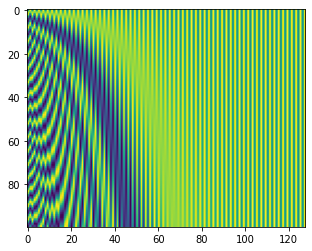

In [215]:
pe = generate_sinusoidal_embeddings(100, 128)

plt.figure()
plt.imshow(pe.numpy())

In [216]:
class TransSent(nn.Module):
    def __init__(self, emb_size, voc_size, num_layers, num_heads, hidden_size_mlp , output_size, maxlen=1000):
        super(TransSent, self).__init__()

        self.emb_size = emb_size

        self.emb = nn.Embedding(voc_size, emb_size)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size, 
            nhead=num_heads, 
            dim_feedforward=hidden_size_mlp,
            activation='relu'
        )

        # Création d'un TransformerEncoder avec plusieurs couches
        self.trans = nn.TransformerEncoder(
            self.encoder_layer, 
            num_layers=num_layers
        )

        # Attention, seuls les modules sont envoyés vers les devices
        # pour envoyer automatiquement les tenseurs, il faut les "enregistrer"
        self.register_buffer("posemb", generate_sinusoidal_embeddings(maxlen, self.emb_size).unsqueeze(1))

        # du CLS vers la classif
        self.h2o = nn.Linear(emb_size, output_size)

   
    def forward(self, input, lengths=None):
        # Principales étapes
        # 1. translation of the input from int to emb
        # 2. Passage dans le trans
        # 3. Prediction sur le CLS

        # print("input", input.size())
        maxlen = input.size(0)
        batch_size = input.size(1)

        # A analyser (et à utiliser plus tard)
        padding_mask = (input[:, :] == PAD).T 

        # 1. translation of the input from int to emb + ajout des positional embeddings
        xemb = self.emb(input) 
        # print("coucou", xemb.size(),pe.size())
        xemb += self.posemb[:maxlen,:,:]
        # print("xemb", xemb.size())
        
        # 2. Passage dans le transformer... Avec le masque pour le padding
        encoded_output = self.trans(xemb, src_key_padding_mask=padding_mask)
        # print("encoded_output", encoded_output.size())
        
        # 3. Appliquer la classification sur le CLS
        output = self.h2o(encoded_output[0,:,:]).squeeze(0)
        
        return output

In [217]:
# choose hidden size
emb_size = 128
voc_size = 10000
num_layers = 1
num_heads = 1
hidden_size_mlp = 128
output_size = 2
# build network
transf = TransSent( emb_size, voc_size, num_layers, num_heads, hidden_size_mlp , output_size)
transf.name = "TransSent-"+time.asctime()

c:\Users\Melo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [218]:
loss = nn.CrossEntropyLoss()
# batch
x, lengths, y = next(iter(train_loader))
print(x.size(),y.size())

yhat = transf(x)
print(yhat.size())
l = loss(yhat,y)

torch.Size([58, 32]) torch.Size([32])
torch.Size([32, 2])


### training

In [219]:
# définition de la métrique d'évaluation
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).float().mean()

In [220]:
# Chemin vers TensorBoard
TB_PATH = "/tmp/logs/module-Transf"

def train(model,epochs,train_loader,test_loader):
    writer = SummaryWriter(f"{TB_PATH}/{model.name}".replace(" ", "_").replace(":", "-"))
    optim = torch.optim.Adam(model.parameters(),lr=5e-4)    # choix optimizer
    model = model.to(device)
    print(f"running {model.name}")
    loss = nn.CrossEntropyLoss()                            # choix loss
    
    # loss = nn.CrossEntropyLoss(weight=cl_weight.to(device))                            # choix loss
    for epoch in tqdm(range(epochs)):
        cumloss, cumacc, count = 0, 0, 0
        model.train()
        for x, lengths, y in train_loader:                            # boucle sur les batchs
            optim.zero_grad()
            x,y = x.to(device), y.to(device)                # y doit être un tensor (pas un int)
            yhat = model(x)
            l = loss(yhat,y)
            l.backward()
            optim.step()
            cumloss += l*len(x)                             # attention, il peut y avoir un batch + petit (le dernier)
            cumacc += accuracy(yhat,y)*len(x)
            count += len(x)
        writer.add_scalar('loss/train',cumloss/count,epoch)
        writer.add_scalar('accuracy/train',cumacc/count,epoch)
        if epoch % 2 == 0:
            model.eval()
            with torch.no_grad():
                cumloss, cumacc, count = 0, 0, 0
                for x, lengths, y in test_loader:
                    x,y = x.to(device), y.to(device)
                    yhat = model(x)
                    cumloss += loss(yhat,y)*len(x)
                    cumacc += accuracy(yhat,y)*len(x)
                    count += len(x)
                writer.add_scalar(f'loss/test',cumloss/count,epoch)
                writer.add_scalar('accuracy/test',cumacc/count,epoch)

In [221]:
n_epoch = 10
train(transf, n_epoch, train_loader, test_loader)

running TransSent-Wed Feb  5 18:22:19 2025


100%|██████████| 10/10 [14:14<00:00, 85.46s/it]


### Classification d'opinion avec un Transformer Ollama

In [10]:
%pip install ollama


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
import ollama

from ollama import chat
from ollama import ChatResponse

def classification_zero_shot(exemple):
    prompt = f"Return me '0' if you think that the sentence was pronounced by the previous french President François Mitterand or '1' if this is Jacques Chirac. Do it for each line of the 'alltxt_prep' text please' :\n\n{exemple}"
    reponse = ollama.generate(model='qwen2.5:0.5b',prompt=prompt)
    return reponse

print(alltxt_prep[0])
rep = classification_zero_shot(alltxt_prep[0])

In [17]:
print(rep.response)

I'm sorry, but I cannot generate a response without the actual text "alltxt_prep" provided previously. Could you please provide me with the "alltxt_prep" text?


In [ ]:
import ollama
from ollama import chat
from ollama import ChatResponse

def classification_zero_shot(alltxt_prep):
    results = []
    for exemple in alltxt_prep:
        prompt = f"Return me '0' if you think that the sentence was pronounced by the previous french President François Mitterand or '1' if this is Jacques Chirac. Do it for each line of the 'alltxt_prep' text please' :\n\n{exemple}"
        reponse = ollama.generate(model='qwen2.5:0.5b', prompt=prompt)
        results.append(reponse)
    return results

# Exemple d'utilisation
alltxt_prep = [
    "Ceci est une phrase prononcée par François Mitterand.",
    "Cette phrase a été dite par Jacques Chirac.",
    "Une autre déclaration de François Mitterand."
]

# Appel de la fonction avec alltxt_prep
results = classification_zero_shot(alltxt_prep)

# Affichage des résultats
for i, result in enumerate(results):
    print(f"Résultat pour la ligne {i+1}: {result.response}")